---
# aCompCor

This notebook aims to streamline the integration of `segmentations` into the `linescanning`-repository so we can create one big dataframe of physiology/aCompCor to be regressed out of the fMRI-signal

Goals

- Implement aCompCor
- Assess effect of aCompCor

In [1]:
from linescanning import utils,prf,dataset,plotting, segmentations
import numpy as np
import warnings
import matplotlib.pyplot as plt
from pRFline import fitting
from scipy import signal
import os
opj = os.path.join

warnings.simplefilter('ignore')
project_dir     = os.environ.get("DIR_PROJECTS")
base_dir        = os.path.join(project_dir, 'hemifield')
deriv_dir       = opj(base_dir, 'derivatives')

plot_vox        = 359
plot_xkcd       = False
np.set_printoptions(precision=3)


/home/gjheij/anaconda3/envs/prfline/lib/python3.10/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/gjheij/anaconda3/envs/prfline/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [12]:
# Load data
sub         = '003'
ses         = 4
task        = "task-pRF"
run         = [2,5]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
anat_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "anat")
trafo_dir   = opj(base_dir, 'testing', 'alignment')
log_dir     = "/mnt/d/FSL/shared/spinoza/programs/project_repos/LineExps/lineprf/logs/sub-003_ses-0_task-pRF_run-imgs"
prf_new     = opj(base_dir, 'derivatives', 'prf', f"sub-{sub}", f"ses-{ses}")
ribbon      = [357,364]

if not os.path.exists(prf_new):
    os.makedirs(prf_new, exist_ok=True)

# aCompCor with manual alignment across run

An issue is that if your subject moves across runs, you will need to designate CSF and WM voxels separately for each run, because otherwise your acompcorr analysis will obviously pick up task-related signals because you’re sampling gray matter. That’s a danger you would want to expressly avoid. Hence, I now do the following:

1) For each run, manually align the runs to the first acquired slice. This slice is the closest to the low-resolution anatomy, so we can use this to transform our segmentations
2) Insert the list of transformations into `linescanning.Segmentations`, so that `call_antsapplytransforms` implements both transformations to warp the segmentations to each run separately

In [9]:
run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir, exclude="run-2")
func_file = utils.get_file_from_substring("bold.mat", run_files)[-1]
ref_slices = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", "acq-1slice", ".nii.gz"], anat_dir, exclude="run-2")[-1]
ref_slices

'/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-6_T1w.nii.gz'

Load the transformation files; should be a `from-fs_to-sesX_desc-genaff.mat`-file and the manually create `from-runX_to-runX.mat`-file

DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-6_bold.mat
 Filtering strategy: 'hp'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]

DATASET: created
Fetching dataframe from attribute 'df_func_zscore'
DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-6_bold.mat
 Filtering strategy: 'hp'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Source dir: /mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-003/ses-1
 Target session: ses-4
 Foldover: FH
 Ref slice: /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-6_T1w.nii.gz
 Found 66 voxels for nuisance regression
 We're good to go!
 Using 5 components for aCompCor (WM/CSF separately)
 Found 1 component(s) in 'csf'-voxels with total explained varian

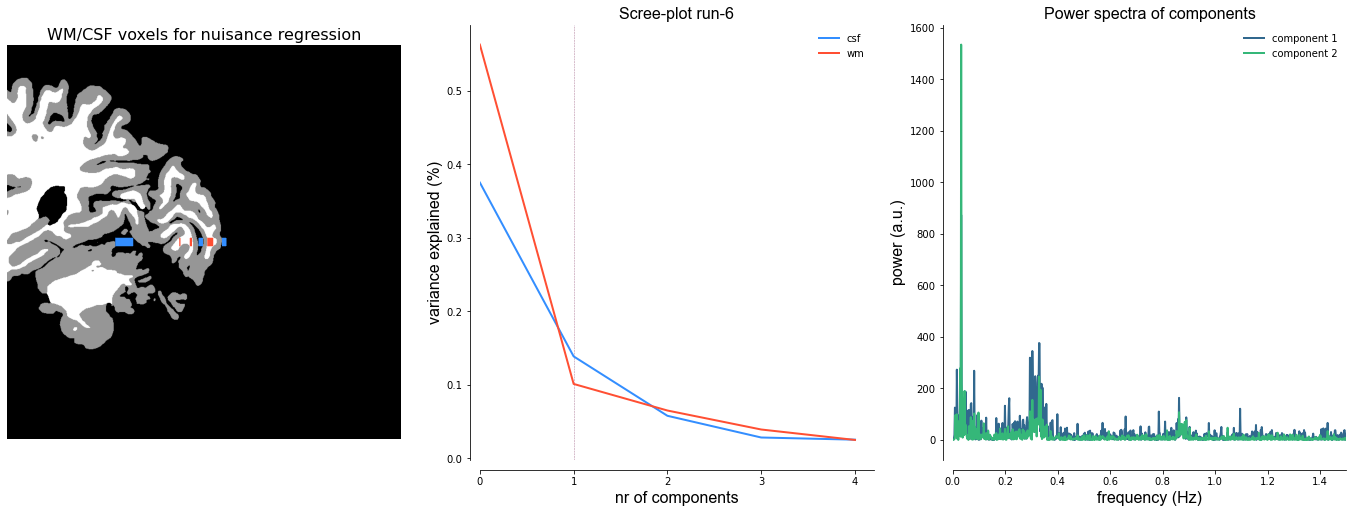

In [32]:
window = 19
order = 3

lp = False

# no acompcor
no_acomp_run6 = dataset.Dataset(func_file,
                                window_size=window,  # needs to be odd
                                low_pass=lp,
                                poly_order=order,
                                use_bids=True,
                                verbose=True,
                                acompcor=False,
                                ref_slice=ref_slices,
                                n_pca=5)

no_acomp_data_run6 = no_acomp_run6.fetch_fmri()

# acompcor
acomp_run6 = dataset.Dataset(func_file,
                                  window_size=window,  # needs to be odd
                                  low_pass=lp,
                                  poly_order=order,
                                  use_bids=True,
                                  verbose=True,
                                  acompcor=True,
                                  ref_slice=ref_slices,
                                  trafo_file=trafo_list,
                                  n_pca=5)

acomp_data_run6 = acomp_run6.fetch_fmri()


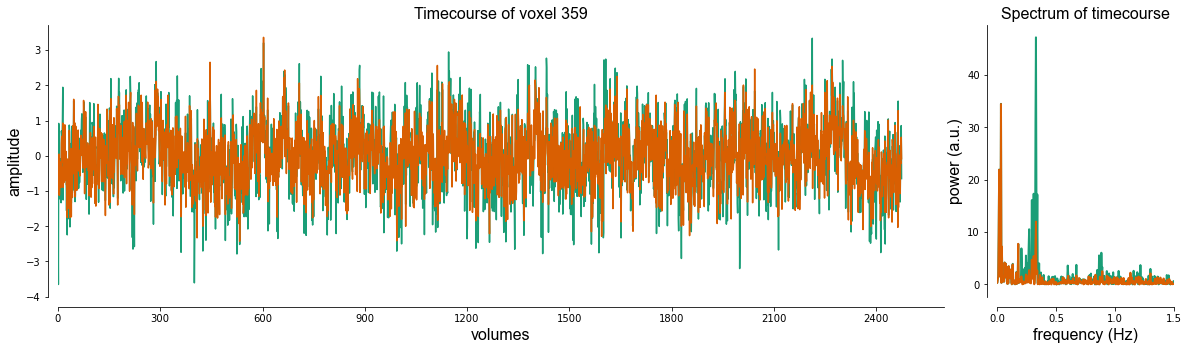

In [33]:
colors = ["#1B9E77", "#D95F02"]
freq_type = "fft"
clipper = 100
tc1 = no_acomp_data_run6['vox 359'].values[:2476]
tc2 = acomp_data_run6['vox 359'].values[:2476]

fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[10, 2], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot([tc1, tc2],
                  color=colors,
                  x_label="volumes",
                  y_label="amplitude",
                  title="Timecourse of voxel 359",
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
tc1_freq = no_acomp_run6.get_freq(tc1, TR=0.105, spectrum_type=freq_type, clip_power=clipper)
tc2_freq = no_acomp_run6.get_freq(tc2, TR=0.105, spectrum_type=freq_type, clip_power=clipper)

plotting.LazyPlot([tc1_freq[1], tc2_freq[1]],
                  xx=tc1_freq[0],
                  color=colors,
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  title="Spectrum of timecourse",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0, 1.5],
                  line_width=2)


# aCompCor NO low-pass filter + filtering of PCAs

In [3]:
run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir, exclude="run-2")
func_file = utils.get_file_from_substring("bold.mat", run_files)[0]
ref_slices = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", "acq-1slice", ".nii.gz"], anat_dir, exclude="run-2")[0]
ref_slices


'/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-4_T1w.nii.gz'

In [7]:
window = 19
order = 3

lp = False

no_acomp_zscore = dataset.Dataset(func_file,
                                  window_size=window,  # needs to be odd
                                  low_pass=lp,
                                  poly_order=order,
                                  use_bids=True,
                                  verbose=True,
                                  acompcor=False,
                                  ref_slice=ref_slices,
                                  n_pca=5)

no_acomp_zscore_data = no_acomp_zscore.fetch_fmri()

DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Filtering strategy: 'hp'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]

DATASET: created
Fetching dataframe from attribute 'df_func_zscore'


DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Filtering strategy: 'hp'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Source dir: /mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-003/ses-1
 Target session: ses-4
 Foldover: FH
 Found 61 voxels for nuisance regression
 We're good to go!
 Using 5 components for aCompCor (WM/CSF separately)
 Found 2 component(s) in 'csf'-voxels with total explained variance of 0.61%
 Found 1 component(s) in 'wm'-voxels with total explained variance of 0.72%
 DCT high-pass filter on components [removes low frequencies <0.19 Hz]

DATASET: created
Fetching dataframe from attribute 'df_func_zscore'


vox 0     vox 1     vox 2     vox 3     vox 4  \
subject run t                                                           
003     4   0.000   -1.422429 -0.695478 -0.156801 -1.976701 -0.489511   
            0.105   -1.643303 -2.024074 -1.359801  0.052946 -2.345672   
            0.210   -0.852312 -0.948696  0.115586  0.027922 -1.277256   
            0.315   -0.355251 -0.784284  0.048885  0.911332  0.632573   
            0.420    0.610527 -0.877298  0.087149 -0.514410  0.526512   
...                       ...       ...       ...       ...       ...   
            545.475  0.201727  0.282105 -0.761739  0.268362 -1.171829   
            545.580 -0.345182 -1.212152  1.040653 -0.846660 -0.185562   
            545.685  0.443534  0.134091 -0.423159  0.618559  0.611712   
            545.790 -1.114475  0.847859  0.141996  0.470899  0.417019   
            545.895 -1.068918 -0.452195 -1.655394 -0.342392  0.370984   

                        vox 5     vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                          ...   
003     4   0.000   -1.200457 -0.528860 -0.859891 -0.806345 -0.675906  ...   
            0.105   -2.528416 -0.100275 -0.479340 -1.295052 -0.578400  ...   
            0.210    0.166109  1.026142 -0.062353 -2.923066 -0.485252  ...   
            0.315   -0.049057  0.438774  2.288616 -0.430432 -0.782547  ...   
            0.420   -1.176708  0.785064 -0.501287  1.840850 -0.401240  ...   
...                       ...       ...       ...       ...       ...  ...   
            545.475 -1.375098  0.597162  0.643089  0.610871 -0.795140  ...   
            545.580 -0.971747  0.495368 -0.981203  0.025431 -0.480385  ...   
            545.685 -1.392330  2.389174  0.091868 -1.082715 -0.250726  ...   
            545.790 -0.720535 -0.147250 -0.422856 -0.041940  0.436679  ...   
            545.895  0.475141  1.029377 -0.279550 -0.160422  0.235740  ...   

                      vox 710   vox 711   vox 712   vox 713   vox 714  \
subject run t                                                           
003     4   0.000    0.584381 -0.975347 -0.305332  1.231055 -1.348191   
            0.105    0.023466 -1.835530  0.542756 -0.744748 -0.652954   
            0.210    0.393877 -0.959003  1.367145 -0.053587  0.271821   
            0.315   -1.185088 -0.234937 -1.162964  0.510536  0.002465   
            0.420   -0.027469  1.841548 -0.366568 -0.313384 -1.738832   
...                       ...       ...       ...       ...       ...   
            545.475 -0.124907 -1.425745 -1.009709  1.072118  1.266395   
            545.580  0.219573 -0.701103  1.027019 -0.936387  0.601518   
            545.685 -0.067153 -0.936547 -0.876143 -0.124056 -0.870175   
            545.790  0.609281 -0.135284 -1.333699 -1.026680 -1.207054   
            545.895  0.606213 -0.322413 -0.121629  1.079194 -0.402520   

                      vox 715   vox 716   vox 717   vox 718   vox 719  
subject run t                                                          
003     4   0.000   -0.708107  0.576161  0.552223  2.053511 -0.125883  
            0.105    0.765900 -0.233634  0.952020 -1.298551 -0.148275  
            0.210    0.682967 -0.574894  0.477587  0.446457 -0.287231  
            0.315   -1.480415 -0.746211  2.440249 -0.825169  1.627324  
            0.420    0.277040  0.883891  0.224839  1.146111  1.522500  
...                       ...       ...       ...       ...       ...  
            545.475 -1.620633 -1.154180 -1.035705 -2.138710  1.020031  
            545.580 -0.534940 -0.403101  0.529779 -1.790889  0.032614  
            545.685 -0.731914  0.579958 -1.780806 -1.340782 -0.595466  
            545.790  2.193367  1.089491 -0.220843 -1.393876 -0.519177  
            545.895 -0.225444  1.758049  1.197973  0.776462  0.463361  

[5200 rows x 720 columns]

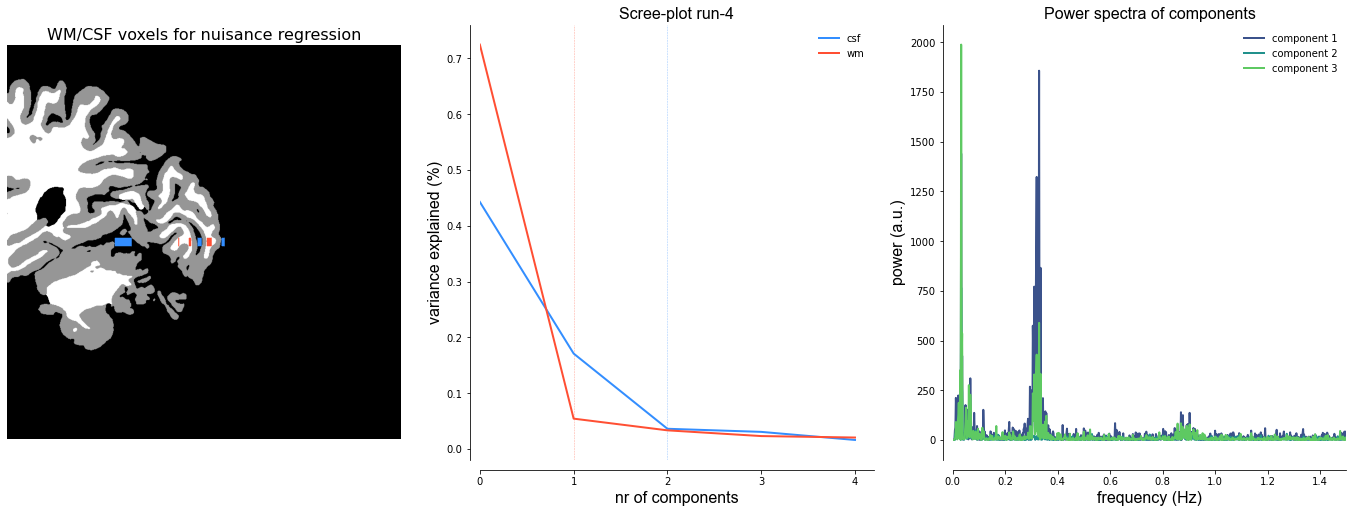

In [8]:

acomp_zscore = dataset.Dataset(func_file,
                               window_size=window,  # needs to be odd
                               low_pass=lp,
                               poly_order=order,
                               use_bids=True,
                               verbose=True,
                               acompcor=True,
                               ref_slice=ref_slices,
                               filter_pca=0.19,
                               n_pca=5)

acomp_zscore_data = acomp_zscore.fetch_fmri()
acomp_zscore_data


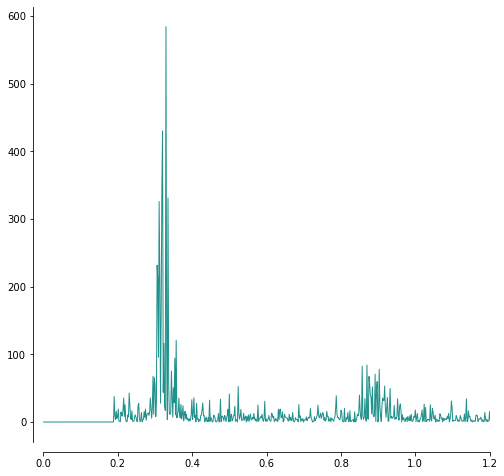

In [9]:
freq_, power_ = acomp_zscore.get_freq(acomp_zscore.confs[:,2], TR=acomp_zscore.TR, spectrum_type="fft")
plotting.LazyPlot(power_, freq_, figsize=(8,8), x_lim=[0,1.2])

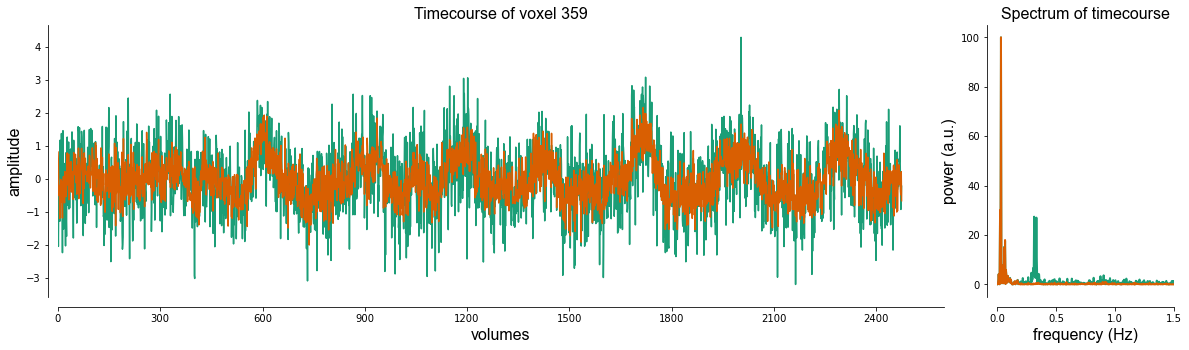

In [12]:
colors = ["#1B9E77", "#D95F02"]
freq_type = "fft"
clipper = 100
tc1 = no_acomp_zscore_data['vox 359'].values[:2476]
tc2 = acomp_zscore_data['vox 359'].values[:2476]

fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[10, 2], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot([tc1, tc2],
                  color=colors,
                  x_label="volumes",
                  y_label="amplitude",
                  title="Timecourse of voxel 359",
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
tc1_freq = acomp_zscore.get_freq(tc1, TR=0.105, spectrum_type=freq_type, clip_power=clipper)
tc2_freq = acomp_zscore.get_freq(
    tc2, TR=0.105, spectrum_type=freq_type, clip_power=clipper)

plotting.LazyPlot([tc1_freq[1], tc2_freq[1]],
                  xx=tc1_freq[0],
                  color=colors,
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  title="Spectrum of timecourse",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0, 1.5],
                  line_width=2)


# aCompCor low-pass filter + filtering of PCAs

In [13]:
window = 15
order = 3

lp = True

no_acomp_zscore_lp = dataset.Dataset(func_file,
                                  window_size=window,  # needs to be odd
                                  low_pass=lp,
                                  poly_order=order,
                                  use_bids=True,
                                  verbose=True,
                                  acompcor=False,
                                  ref_slice=ref_slices,
                                  n_pca=5)

no_acomp_zscore_data_lp = no_acomp_zscore_lp.fetch_fmri()


DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Filtering strategy: 'lp'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Using high-pass filtered data for low-pass filtering
 Savitsky-Golay low-pass filter [removes high frequences] (window=15, order=3)

DATASET: created
Fetching dataframe from attribute 'df_func_zscore'


DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Filtering strategy: 'lp'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Source dir: /mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-003/ses-1
 Target session: ses-4
 Foldover: FH
 Ref slice: /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-4_T1w.nii.gz
 Found 61 voxels for nuisance regression
 We're good to go!
 Using 5 components for aCompCor (WM/CSF separately)
 Found 2 component(s) in 'csf'-voxels with total explained variance of 0.61%
 Found 1 component(s) in 'wm'-voxels with total explained variance of 0.72%
 DCT high-pass filter on components [removes low frequencies <0.2 Hz]
 Using aCompCor-data for low-pass filtering
 Savitsky-Golay low-pass filter [removes high frequences] (window=15, order=3)

DATASET: created
Fetching dataframe from

vox 0     vox 1     vox 2     vox 3     vox 4  \
subject run t                                                           
003     4   0.000   -1.742765 -1.214660 -0.356628 -1.432958 -1.713537   
            0.105   -1.093751 -1.138862 -0.434488 -0.700884 -0.897626   
            0.210   -0.652677 -1.048812 -0.488788 -0.168817 -0.324230   
            0.315   -0.385186 -0.947208 -0.520231  0.187535  0.041739   
            0.420   -0.256916 -0.836748 -0.529525  0.392462  0.235367   
...                       ...       ...       ...       ...       ...   
            545.475  0.140554  0.079028  0.024685  0.270731 -0.945392   
            545.580  0.078706  0.054582 -0.051238  0.273768 -0.731243   
            545.685 -0.147525  0.009314 -0.234467  0.202507 -0.354588   
            545.790 -0.583179 -0.061656 -0.549799  0.040016  0.213169   
            545.895 -1.273298 -0.163208 -1.022029 -0.230633  1.000624   

                        vox 5     vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                          ...   
003     4   0.000   -1.280265 -0.455839 -0.947113 -1.966480 -0.844244  ...   
            0.105   -1.287684  0.118612 -0.180131 -1.172847 -0.553912  ...   
            0.210   -1.162815  0.475077  0.291587 -0.559615 -0.347224  ...   
            0.315   -0.937914  0.647934  0.516099 -0.108877 -0.210874  ...   
            0.420   -0.645241  0.671558  0.541458  0.197275 -0.131555  ...   
...                       ...       ...       ...       ...       ...  ...   
            545.475 -0.670426  0.110114 -0.392986 -0.013886  0.446152  ...   
            545.580 -0.704217  0.331677 -0.315882 -0.036180  0.450968  ...   
            545.685 -0.644697  0.578131 -0.277144 -0.094994  0.353759  ...   
            545.790 -0.466012  0.849555 -0.294284 -0.198902  0.126235  ...   
            545.895 -0.142311  1.146028 -0.384814 -0.356477 -0.259895  ...   

                      vox 710   vox 711   vox 712   vox 713   vox 714  \
subject run t                                                           
003     4   0.000    0.668866 -1.572305  0.112276  0.359412 -0.895892   
            0.105    0.053143 -0.948158  0.123001  0.326887 -0.732984   
            0.210   -0.299916 -0.493841  0.123401  0.296309 -0.621655   
            0.315   -0.437369 -0.186266  0.114418  0.263748 -0.552682   
            0.420   -0.406274 -0.002343  0.096993  0.225270 -0.516847   
...                       ...       ...       ...       ...       ...   
            545.475  0.075351 -0.606371  0.133243 -0.275839 -0.080116   
            545.580  0.085706 -0.671535 -0.012899 -0.209206 -0.291349   
            545.685  0.173081 -0.662254 -0.227608 -0.099301 -0.477839   
            545.790  0.356232 -0.558830 -0.519204  0.065153 -0.621671   
            545.895  0.653917 -0.341563 -0.896006  0.295437 -0.704929   

                      vox 715   vox 716   vox 717   vox 718   vox 719  
subject run t                                                          
003     4   0.000    0.009528  0.433939  0.904688  1.043657 -0.070761  
            0.105   -0.084291 -0.060860  0.927453  0.460681  0.160021  
            0.210   -0.171954 -0.347358  0.806873  0.050094  0.277669  
            0.315   -0.250264 -0.461107  0.580137 -0.211981  0.302460  
            0.420   -0.316025 -0.437659  0.284434 -0.349422  0.254668  
...                       ...       ...       ...       ...       ...  
            545.475 -0.134896 -0.226682 -0.452495 -1.416101 -0.106139  
            545.580 -0.124956  0.025545 -0.403517 -1.594330 -0.050482  
            545.685 -0.010053  0.411298 -0.235719 -1.441052 -0.010423  
            545.790  0.238791  0.950318  0.081335 -0.866977  0.008082  
            545.895  0.650551  1.662343  0.578081  0.217186 -0.000920  

[5200 rows x 720 columns]

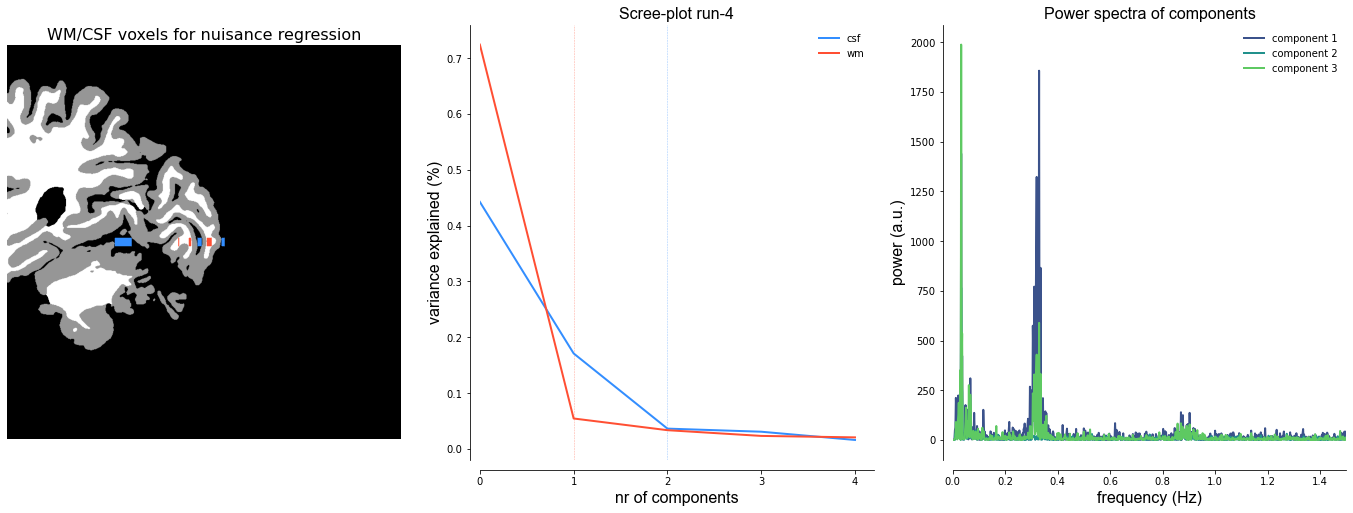

In [19]:

acomp_zscore_lp = dataset.Dataset(func_file,
                                  window_size=window,  # needs to be odd
                                  low_pass=lp,
                                  poly_order=order,
                                  use_bids=True,
                                  verbose=True,
                                  acompcor=True,
                                  ref_slice=ref_slices,
                                  filter_pca=0.2,
                                  n_pca=5)

acomp_zscore_data_lp = acomp_zscore_lp.fetch_fmri()
acomp_zscore_data_lp

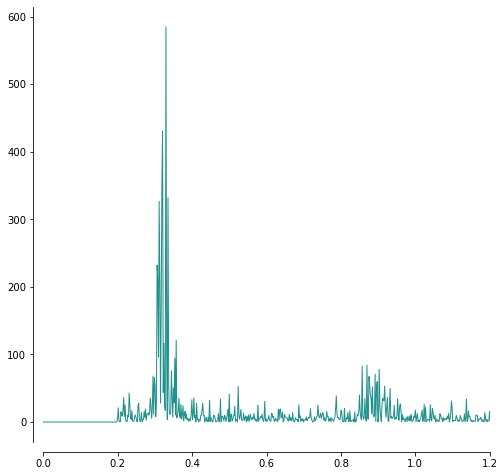

In [20]:
freq_, power_ = acomp_zscore_lp.get_freq(acomp_zscore_lp.confs[:,2], TR=acomp_zscore.TR, spectrum_type="fft")
plotting.LazyPlot(power_, freq_, figsize=(8,8), x_lim=[0,1.2])

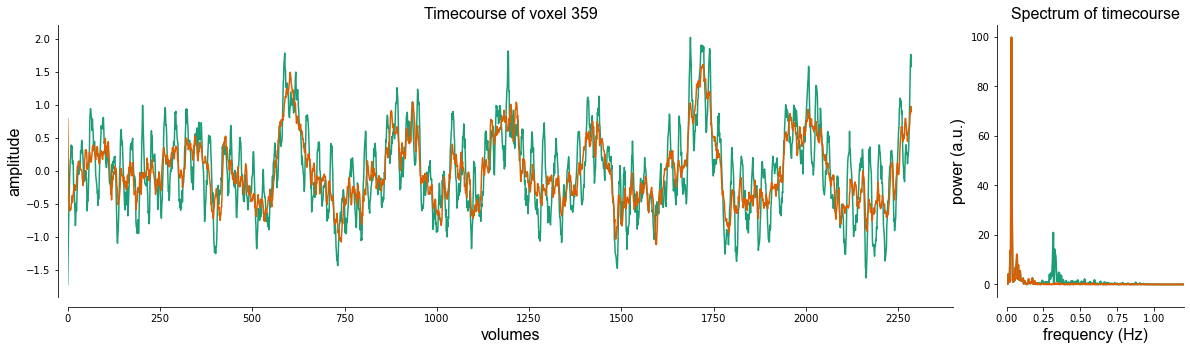

In [21]:
colors = ["#1B9E77", "#D95F02"]
freq_type = "fft"
clipper = 100
tc1 = no_acomp_zscore_data_lp['vox 359'].values[:2286]
tc2 = acomp_zscore_data_lp['vox 359'].values[:2286]

fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[10, 2], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot([tc1, tc2],
                  color=colors,
                  x_label="volumes",
                  y_label="amplitude",
                  title="Timecourse of voxel 359",
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
tc1_freq = acomp_zscore_lp.get_freq(tc1, TR=0.105, spectrum_type=freq_type, clip_power=clipper)
tc2_freq = acomp_zscore_lp.get_freq(
    tc2, TR=0.105, spectrum_type=freq_type, clip_power=clipper)

plotting.LazyPlot([tc1_freq[1], tc2_freq[1]],
                  xx=tc1_freq[0],
                  color=colors,
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  title="Spectrum of timecourse",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0, 1.2],
                  line_width=2)

